<a href="https://colab.research.google.com/github/sanker1208/project/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

In [ ]:
!kaggle datasets download -d threnjen/2019-airline-delays-and-cancellations

In [ ]:
!ls

In [ ]:
!unzip 2019-airline-delays-and-cancellations.zip

In [ ]:
!pip uninstall pandas-profiling -y
!pip install pandas-profiling
!pip install category_encoders
!pip install eli5
!pip install pdpbox

In [4]:
from IPython.display import display
import pandas as pd
from glob import glob
from pandas_profiling import ProfileReport
from sklearn.metrics import classification_report
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from google.colab import output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, model_selection
from xgboost import XGBClassifier

# raw_data

In [5]:
ontime_01 = pd.read_csv('/content/raw_data/ONTIME_REPORTING_01.csv')
ontime_01

MONTH  DAY_OF_MONTH  ...  LATE_AIRCRAFT_DELAY Unnamed: 32
0           1             6  ...                  NaN         NaN
1           1             7  ...                  NaN         NaN
2           1             8  ...                  NaN         NaN
3           1             9  ...                  NaN         NaN
4           1            10  ...                  NaN         NaN
...       ...           ...  ...                  ...         ...
583980      1            30  ...                  NaN         NaN
583981      1            30  ...                  NaN         NaN
583982      1            30  ...                  NaN         NaN
583983      1            30  ...                 11.0         NaN
583984      1            30  ...                  NaN         NaN

[583985 rows x 33 columns]

In [6]:
profile = ProfileReport(ontime_01, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
temp = ontime_01.copy()

ontime_features = ['date', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM']

def make_date(temp):
  temp['MONTH'] = temp['MONTH'].astype(str)
  temp['DAY_OF_MONTH'] = temp['DAY_OF_MONTH'].astype(str)

  temp['date'] = '2019-' + temp['MONTH'] + '-' + temp['DAY_OF_MONTH']
  temp['date'] = pd.to_datetime(temp['date'])
  temp = temp[ontime_features]
  return temp

make_date(temp)


date  DAY_OF_WEEK OP_UNIQUE_CARRIER TAIL_NUM
0      2019-01-06            7                9E   N8694A
1      2019-01-07            1                9E   N8970D
2      2019-01-08            2                9E   N820AY
3      2019-01-09            3                9E   N840AY
4      2019-01-10            4                9E   N8969A
...           ...          ...               ...      ...
583980 2019-01-30            3                UA   N819UA
583981 2019-01-30            3                UA   N37462
583982 2019-01-30            3                UA   N37462
583983 2019-01-30            3                UA   N26967
583984 2019-01-30            3                UA   N821UA

[583985 rows x 4 columns]

# train_test_small

In [8]:
df = pd.read_csv('train_test_small.csv')
df.shape

(502050, 26)

In [9]:
df.head().T

0  ...                       4
MONTH                                               1  ...                       1
DAY_OF_WEEK                                         7  ...                       7
DEP_DEL15                                           0  ...                       0
DISTANCE_GROUP                                      2  ...                       7
DEP_BLOCK                                     MORNING  ...           EARLY_MORNING
SEGMENT_NUMBER                                      1  ...                       1
CONCURRENT_FLIGHTS                                109  ...                      10
NUMBER_OF_SEATS                                   143  ...                     182
CARRIER_NAME                   Southwest Airlines Co.  ...        Spirit Air Lines
AIRPORT_FLIGHTS_MONTH                           13056  ...                   13056
AIRLINE_FLIGHTS_MONTH                          107363  ...                   15023
AIRLINE_AIRPORT_FLIGHTS_MONTH                    5873  ...                    1257
AVG_MONTHLY_PASS_AIRPORT                      1903352  ...                 1903352
AVG_MONTHLY_PASS_AIRLINE                     13382999  ...                 2688839
FLT_ATTENDANTS_PER_PASS                   6.17824e-05  ...             9.17372e-06
GROUND_SERV_PER_PASS                      9.88941e-05  ...             0.000124651
PLANE_AGE                                           8  ...                       1
DEPARTING_AIRPORT              McCarran International  ...  McCarran International
LATITUDE                                        36.08  ...                   36.08
LONGITUDE                                    -115.152  ...                -115.152
PREVIOUS_AIRPORT                                 NONE  ...                    NONE
PRCP                                                0  ...                       0
SNOW                                                0  ...                       0
SNWD                                                0  ...                       0
TMAX                                               65  ...                      65
AWND                                             2.91  ...                    2.91

[26 rows x 5 columns]

In [10]:
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
for col in df.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df[col].isnull().sum() / df[col].shape[0]))
    print(msg)

column:      MONTH	 Percent of NaN value: 0.00%
column: DAY_OF_WEEK	 Percent of NaN value: 0.00%
column:  DEP_DEL15	 Percent of NaN value: 0.00%
column: DISTANCE_GROUP	 Percent of NaN value: 0.00%
column:  DEP_BLOCK	 Percent of NaN value: 0.00%
column: SEGMENT_NUMBER	 Percent of NaN value: 0.00%
column: CONCURRENT_FLIGHTS	 Percent of NaN value: 0.00%
column: NUMBER_OF_SEATS	 Percent of NaN value: 0.00%
column: CARRIER_NAME	 Percent of NaN value: 0.00%
column: AIRPORT_FLIGHTS_MONTH	 Percent of NaN value: 0.00%
column: AIRLINE_FLIGHTS_MONTH	 Percent of NaN value: 0.00%
column: AIRLINE_AIRPORT_FLIGHTS_MONTH	 Percent of NaN value: 0.00%
column: AVG_MONTHLY_PASS_AIRPORT	 Percent of NaN value: 0.00%
column: AVG_MONTHLY_PASS_AIRLINE	 Percent of NaN value: 0.00%
column: FLT_ATTENDANTS_PER_PASS	 Percent of NaN value: 0.00%
column: GROUND_SERV_PER_PASS	 Percent of NaN value: 0.00%
column:  PLANE_AGE	 Percent of NaN value: 0.00%
column: DEPARTING_AIRPORT	 Percent of NaN value: 0.00%
column:   LAT

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502050 entries, 0 to 502049
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          502050 non-null  int64  
 1   DAY_OF_WEEK                    502050 non-null  int64  
 2   DEP_DEL15                      502050 non-null  int64  
 3   DISTANCE_GROUP                 502050 non-null  int64  
 4   DEP_BLOCK                      502050 non-null  object 
 5   SEGMENT_NUMBER                 502050 non-null  int64  
 6   CONCURRENT_FLIGHTS             502050 non-null  int64  
 7   NUMBER_OF_SEATS                502050 non-null  int64  
 8   CARRIER_NAME                   502050 non-null  object 
 9   AIRPORT_FLIGHTS_MONTH          502050 non-null  int64  
 10  AIRLINE_FLIGHTS_MONTH          502050 non-null  int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  502050 non-null  int64  
 12  AVG_MONTHLY_PASS_AIRPORT      

In [13]:
df

MONTH  DAY_OF_WEEK  DEP_DEL15  DISTANCE_GROUP  ... SNOW  SNWD  TMAX   AWND
0           1            7          0               2  ...  0.0   0.0  65.0   2.91
1           1            7          0               7  ...  0.0   0.0  65.0   2.91
2           1            7          0               7  ...  0.0   0.0  65.0   2.91
3           1            7          0               9  ...  0.0   0.0  65.0   2.91
4           1            7          0               7  ...  0.0   0.0  65.0   2.91
...       ...          ...        ...             ...  ...  ...   ...   ...    ...
502045      1            2          0               1  ...  0.0   0.0  79.0  11.86
502046      1            2          0               1  ...  0.0   0.0  79.0  11.86
502047      1            2          0               1  ...  0.0   0.0  79.0  11.86
502048      1            2          0               1  ...  0.0   0.0  79.0  11.86
502049      1            2          0               1  ...  0.0   0.0  79.0  11.86

[502050 rows x 26 columns]

In [79]:
from sklearn.model_selection import train_test_split

target = 'DEP_DEL15'
train = df.copy()

train, test = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train, val = train_test_split(train, train_size=0.75, test_size=0.25, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((301230, 26), (100410, 26), (100410, 26))

In [80]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [81]:
# 기준모델
major = y_train.mode()[0]
base_pred = [major] * len(y_train)

print(classification_report(y_train, base_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90    248620
           1       0.00      0.00      0.00     52610

    accuracy                           0.83    301230
   macro avg       0.41      0.50      0.45    301230
weighted avg       0.68      0.83      0.75    301230



In [82]:
from google.colab import output

In [83]:
%%time
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=2, max_depth = 10)
)

pipe.fit(X_train, y_train);



print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증세트 정확도', pipe.score(X_val, y_val))

y_pred = pipe.predict(X_val)
print('검증 f1:', f1_score(y_val, y_pred))

print(classification_report(y_val, y_pred))
# 항공지연을 지연이 없다고 예측했을때 손실이 크므로 recall이 더 중요

훈련 정확도:  0.8358032068519072
검증세트 정확도 0.8331939049895428
검증 f1: 0.12193971166448231
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     82874
           1       0.76      0.07      0.12     17536

    accuracy                           0.83    100410
   macro avg       0.80      0.53      0.51    100410
weighted avg       0.82      0.83      0.77    100410

CPU times: user 38.2 s, sys: 108 ms, total: 38.3 s
Wall time: 38.1 s


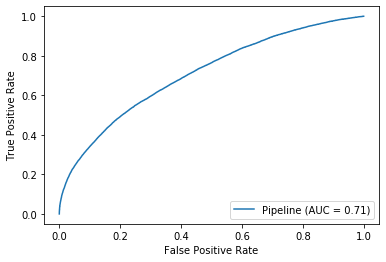

In [84]:
metrics.plot_roc_curve(pipe, X_val, y_val)

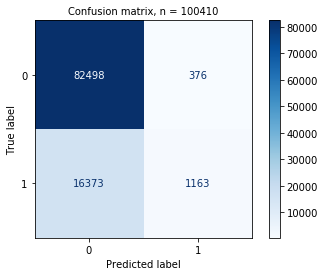

In [85]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax,
                            values_format = '');
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=10)
plt.show()

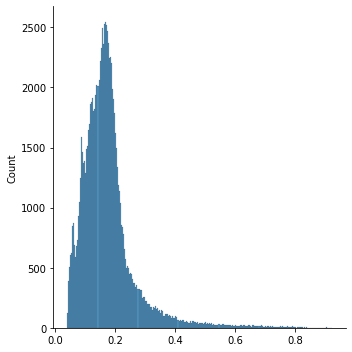

In [86]:
import seaborn as sns

y_pred_proba = pipe.predict_proba(X_val)[:, 1]

sns.displot(y_pred_proba);

In [87]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# pipe_rf = make_pipeline(
#       OrdinalEncoder(),
#       SimpleImputer(strategy='median'),
#       RandomForestClassifier(max_depth = 10, n_jobs=-1, random_state=2)
# )
    
# parameters = {   
#     'randomforestclassifier__max_depth': range(1, 20, 2), 
#     'randomforestclassifier__max_features': range(1, 20, 2), 
#     'randomforestclassifier__min_samples_leaf' : range(1, 20, 2)
# }
    

# rf_classifier = RandomizedSearchCV(
#     pipe_rf, 
#     param_distributions=parameters, 
#     n_iter=10, 
#     cv=5,
#     scoring='accuracy',
#     verbose=1,
# )

# rf_classifier.fit(X_train, y_train);

In [88]:
# print('Best Parameters: ', rf_classifier.best_params_)
# print('MAE: ', -rf_classifier.best_score_)

# Best Parameters:  {'randomforestclassifier__min_samples_leaf': 7, 'randomforestclassifier__max_features': 17, 'randomforestclassifier__max_depth': 17}
# MAE:  -0.8382332437008266

In [89]:
%%time
# pipe_best = rf_classifier.best_estimator_
pipe_best = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(max_depth = 17, min_samples_leaf=7, max_features=17, n_jobs=-1, random_state=2)
)

pipe_best.fit(X_train, y_train);

print('훈련 정확도: ', pipe_best.score(X_train, y_train))
print('검증세트 정확도', pipe_best.score(X_val, y_val))

y_pred_best = pipe_best.predict(X_val)
print('검증 f1:', f1_score(y_val, y_pred_best))

print(classification_report(y_val, y_pred_best))

훈련 정확도:  0.8563622481160575
검증세트 정확도 0.8398067921521761
검증 f1: 0.24423248602170744
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     82874
           1       0.69      0.15      0.24     17536

    accuracy                           0.84    100410
   macro avg       0.77      0.57      0.58    100410
weighted avg       0.82      0.84      0.79    100410

CPU times: user 3min 54s, sys: 287 ms, total: 3min 54s
Wall time: 1min 1s


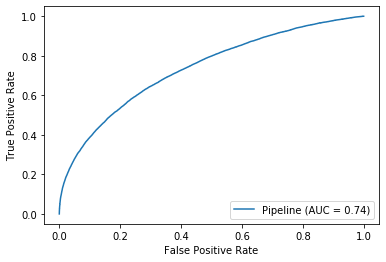

In [90]:
metrics.plot_roc_curve(pipe_best, X_val, y_val)

In [91]:
from sklearn.pipeline import Pipeline

pipe_best.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['DEP_BLOCK', 'CARRIER_NAME', 'DEPARTING_AIRPORT',
                      'PREVIOUS_AIRPORT'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value',
                mapping=[{'col': 'DEP_BLOCK', 'data_type': dtype('O'),
                          'mapping': AFTERNOON        1
 MORNING          2
 MIDDAY           3
 EVENING          4
 LATE_NIGHT       5
 EARLY_MORNING    6
 NaN             -2
 dtype: int64},
                         {'col': 'CARRIER_NAME', 'data_type': dtype('O'),
                          'mapping': Sky...
 Lihue Airport                       83
 Long Beach Daugherty Field          84
 NaN                                 -2
 Length: 85, dtype: int64},
                         {'col': 'PREVIOUS_AIRPORT', 'data_type': dtype('O'),
                          'mapping': Stewart International                1
 Houston Intercontinental             2
 NONE                                 3
 L

In [92]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

permuter = PermutationImportance(
    pipe_best.named_steps['randomforestclassifier'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = pipe_best.named_steps['ordinalencoder'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [93]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(permuter, feature_names = feature_names, top=None)

In [94]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [95]:
# pipe_rf_s = make_pipeline(
#       OrdinalEncoder(),
#       SimpleImputer(strategy='median'),
#       RandomForestClassifier(n_jobs=-1, random_state=2)
# )
    
# parameters = {   
#     'randomforestclassifier__max_depth': range(1, 20, 2), 
#     'randomforestclassifier__max_features': range(1, 13, 2), 
#     'randomforestclassifier__min_samples_leaf' : range(1, 20, 2)
# }
    

# rf_s_classifier = RandomizedSearchCV(
#     pipe_rf_s, 
#     param_distributions=parameters, 
#     n_iter=10, 
#     cv=5,
#     scoring='accuracy',
#     verbose=1,
# )

# rf_s_classifier.fit(X_train_selected, y_train);

In [96]:
# print('Best Parameters: ', rf_s_classifier.best_params_)
# print('MAE: ', rf_s_classifier.best_score_)

# Best Parameters:  {'randomforestclassifier__min_samples_leaf': 15, 'randomforestclassifier__max_features': 9, 'randomforestclassifier__max_depth': 19}
# MAE:  0.8385718553928891

In [97]:
# pipe_rf_s = rf_s_classifier.best_estimator_
%%time
pipe_rf_s = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='median'),
      RandomForestClassifier(n_jobs=-1, random_state=2, min_samples_leaf=15, max_features=9, max_depth=19)
)

pipe_rf_s.fit(X_train_selected, y_train);

y_pred_selected = pipe_rf_s.predict(X_val_selected)

print(classification_report(y_val, y_pred_selected))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     82874
           1       0.69      0.14      0.23     17536

    accuracy                           0.84    100410
   macro avg       0.77      0.56      0.57    100410
weighted avg       0.82      0.84      0.79    100410

CPU times: user 2min 17s, sys: 199 ms, total: 2min 17s
Wall time: 35.5 s


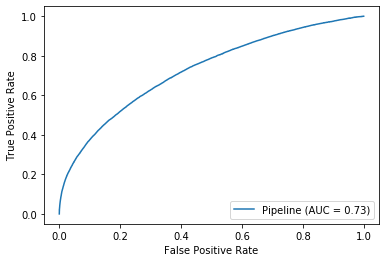

In [98]:
metrics.plot_roc_curve(pipe_rf_s, X_val_selected, y_val)

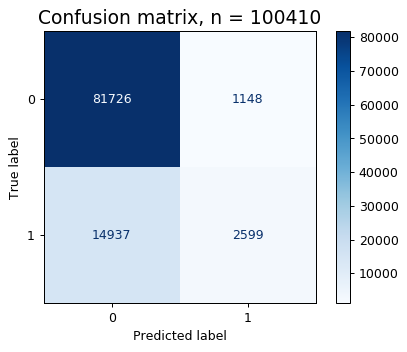

In [99]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_best, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax,
                            values_format = '');
fig.dpi = 90
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [100]:
from sklearn.linear_model import LogisticRegression

# pipe_logistic = make_pipeline(
#       OrdinalEncoder(cols=['DEP_BLOCK', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT']),
#       SimpleImputer(strategy='median'),
#       LogisticRegression(random_state=2, n_jobs=-1, class_weight='balanced')
# )

# C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]   

# parameters = {   
#     'logisticregression__C': C
# }

# lg_classifier = RandomizedSearchCV(
#     pipe_logistic, 
#     param_distributions=parameters, 
#     n_iter=30, 
#     cv=5,
#     scoring='accuracy',
#     verbose=1,
# )

# lg_classifier.fit(X_train, y_train);

# print('Best Parameters: ', lg_classifier.best_params_)
# print('MAE: ', lg_classifier.best_score_)
# Best Parameters:  {'logisticregression__C': 0.0001}
# MAE:  0.5767420243667629

In [101]:
%%time
# pipe_lg_best = lg_classifier.best_estimator_
pipe_lg_best = make_pipeline(
      OrdinalEncoder(cols=['DEP_BLOCK', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT']),
      SimpleImputer(strategy='median'),
      LogisticRegression(random_state=2, n_jobs=-1, class_weight='balanced', C=0.0001)
)

pipe_lg_best.fit(X_train, y_train)

print('훈련 정확도: ', pipe_lg_best.score(X_train, y_train))
print('검증세트 정확도', pipe_lg_best.score(X_val, y_val))

y_pred_lg_best = pipe_lg_best.predict(X_val)
print('검증 f1:', f1_score(y_val, y_pred_lg_best))

print(classification_report(y_val, y_pred_lg_best))

훈련 정확도:  0.5775918733193905
검증세트 정확도 0.5757593865152874
검증 f1: 0.27055721086338574
              precision    recall  f1-score   support

           0       0.84      0.60      0.70     82874
           1       0.19      0.45      0.27     17536

    accuracy                           0.58    100410
   macro avg       0.52      0.53      0.49    100410
weighted avg       0.73      0.58      0.63    100410

CPU times: user 2.22 s, sys: 1.24 s, total: 3.46 s
Wall time: 6.32 s


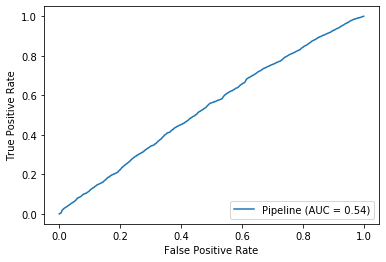

In [102]:
metrics.plot_roc_curve(pipe_lg_best, X_val, y_val)

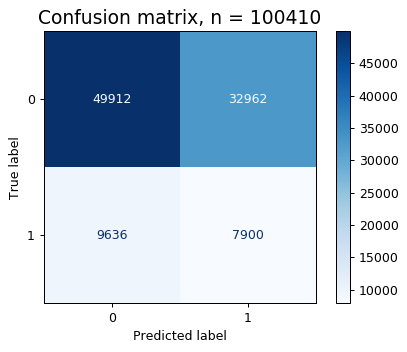

In [103]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_lg_best, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax,
                            values_format = '');
fig.dpi = 90
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [104]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

pipe_tree = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth = 17, min_samples_leaf=7, max_features=17, random_state=2, class_weight='balanced')
)

pipe_tree.fit(X_train, y_train);

print('훈련 정확도: ', pipe_tree.score(X_train, y_train))
print('검증세트 정확도', pipe_tree.score(X_val, y_val))

y_pred_tree = pipe_tree.predict(X_val)
print('검증 f1:', f1_score(y_val, y_pred_tree))

print(classification_report(y_val, y_pred_tree))

훈련 정확도:  0.7330378780333964
검증세트 정확도 0.67095906782193
검증 f1: 0.37439169869913463
              precision    recall  f1-score   support

           0       0.88      0.69      0.78     82874
           1       0.28      0.56      0.37     17536

    accuracy                           0.67    100410
   macro avg       0.58      0.63      0.58    100410
weighted avg       0.78      0.67      0.71    100410

CPU times: user 4.27 s, sys: 42.1 ms, total: 4.31 s
Wall time: 4.29 s


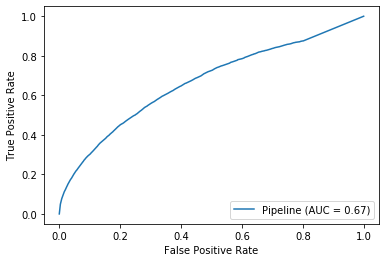

In [105]:
from sklearn import metrics, model_selection

metrics.plot_roc_curve(pipe_tree, X_val, y_val)

(array([5.36536e+05, 1.89310e+04, 6.47300e+03, 2.70200e+03, 1.20200e+03,
        5.76000e+02, 3.07000e+02, 1.79000e+02, 1.18000e+02, 1.09000e+02,
        7.90000e+01, 6.10000e+01, 6.80000e+01, 6.20000e+01, 6.50000e+01,
        4.80000e+01, 3.40000e+01, 2.30000e+01, 1.50000e+01, 1.30000e+01,
        7.00000e+00, 1.70000e+01, 2.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([   0.  ,   66.04,  132.08,  198.12,  264.16,  330.2 ,  396.24,
         462.28,  528.32,  594.36,  660.4 ,  726.44,  792.48,  858.52,
         924.56,  990.6 , 1056.64, 1122.68, 1188.72, 1254.76, 1320.8 ,
        1386.84, 1452.88, 1518.92, 1584.96, 1651.  ]),
 <a list of 25 Patch objects>)

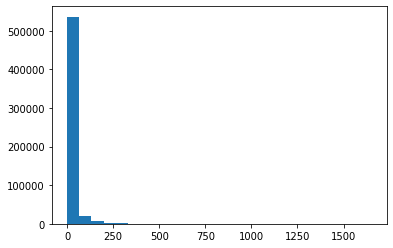

In [106]:
ontime_01
plt.hist(ontime_01['DEP_DELAY_NEW'], bins=25)

(array([403859.,  15988.,  18603.,  10267.,   8886.,  11100.,   6353.,
          5635.,   7370.,   4371.,   3856.,   5336.,   3275.,   4255.,
          2652.,   2369.,   3270.,   2048.,   1884.,   2673.,   1625.,
          1562.,   2213.,   1341.,   1937.]),
 array([ 0.  ,  2.36,  4.72,  7.08,  9.44, 11.8 , 14.16, 16.52, 18.88,
        21.24, 23.6 , 25.96, 28.32, 30.68, 33.04, 35.4 , 37.76, 40.12,
        42.48, 44.84, 47.2 , 49.56, 51.92, 54.28, 56.64, 59.  ]),
 <a list of 25 Patch objects>)

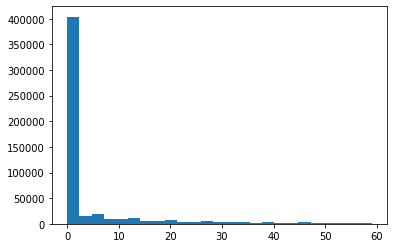

In [107]:
delay_01 = ontime_01.loc[ontime_01['DEP_DELAY_NEW'] < 60]
plt.hist(delay_01['DEP_DELAY_NEW'], bins=25)

(array([15877., 41971., 38450., 39031., 34384., 35768., 36774., 36918.,
        33413., 35925., 35988., 35250., 37254., 34670., 31823., 26057.,
        17844., 13019.,  3569.]),
 array([ 0.        ,  0.94736842,  1.89473684,  2.84210526,  3.78947368,
         4.73684211,  5.68421053,  6.63157895,  7.57894737,  8.52631579,
         9.47368421, 10.42105263, 11.36842105, 12.31578947, 13.26315789,
        14.21052632, 15.15789474, 16.10526316, 17.05263158, 18.        ]),
 <a list of 19 Patch objects>)

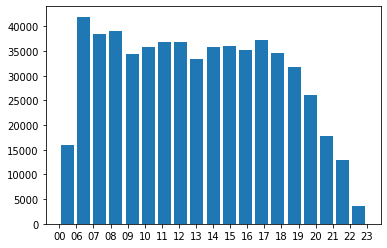

In [108]:
plt.hist(ontime_01['DEP_TIME_BLK'].str[:2].sort_values(), bins=19, rwidth = 0.8)

In [109]:
pipe_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

In [110]:
pipe_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ordinalencoder', 'simpleimputer', 'xgbclassifier', 'ordinalencoder__cols', 'ordinalencoder__drop_invariant', 'ordinalencoder__handle_missing', 'ordinalencoder__handle_unknown', 'ordinalencoder__mapping', 'ordinalencoder__return_df', 'ordinalencoder__verbose', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__gamma', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__nthread', 'xgbclassifier__objective', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_

In [111]:
from xgboost import XGBClassifier

# pipe_xgb = make_pipeline(
#       OrdinalEncoder(),
#       SimpleImputer(strategy='median'),
#       XGBClassifier(n_jobs=-1, random_state=2)
# )
    
# parameters = {
#         'xgbclassifier__silent': [False],
#         'xgbclassifier__max_depth': [6, 10, 15, 20],
#         'xgbclassifier__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
#         'xgbclassifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'xgbclassifier__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'xgbclassifier__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'xgbclassifier__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
#         'xgbclassifier__gamma': [0, 0.25, 0.5, 1.0],
#         'xgbclassifier__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
#         'xgbclassifier__n_estimators': [100]}
    

# xgb_classifier = RandomizedSearchCV(pipe_xgb, parameters, n_iter=20,
#                             n_jobs=1, verbose=2, cv=2,
#                             scoring='neg_log_loss', refit=False, random_state=42)

# xgb_classifier.fit(X_train, y_train);
# best_xgb_params = xgb_classifier.best_params_
# print(best_xgb_params)
# output.eval_js('new Audio("https://freesound.org/data/previews/584/584123_13121163-lq.mp3").play()')

In [112]:
%%time
pipe_xgb_best = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='median'),
      XGBClassifier(n_jobs=-1, random_state=2, subsample=0.7, silent=False, reg_lambda=50.0, n_estimators=100, min_child_weight=5.0,
                    max_depth=6, learning_rate=0.2, gamma=1.0, colsample_bytree=0.9, colsample_bylevel=0.4)
)

pipe_xgb_best.fit(X_train, y_train)

print('훈련 정확도: ', pipe_xgb_best.score(X_train, y_train))
print('검증세트 정확도', pipe_xgb_best.score(X_val, y_val))

y_pred_xgb_best = pipe_xgb_best.predict(X_val)
print('검증 f1:', f1_score(y_val, y_pred_xgb_best))

print(classification_report(y_val, y_pred_xgb_best))

훈련 정확도:  0.8379909039604289
검증세트 정확도 0.8362015735484514
검증 f1: 0.19444580496644953
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     82874
           1       0.69      0.11      0.19     17536

    accuracy                           0.84    100410
   macro avg       0.76      0.55      0.55    100410
weighted avg       0.81      0.84      0.78    100410

CPU times: user 59.4 s, sys: 66 ms, total: 59.5 s
Wall time: 16.5 s


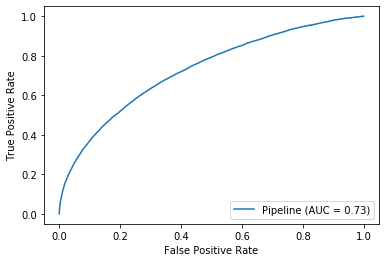

In [113]:
metrics.plot_roc_curve(pipe_xgb_best, X_val, y_val)

In [114]:
# 기준모델
major = y_train.mode()[0]
base_pred = [major] * len(y_train)

print(classification_report(y_train, base_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90    248620
           1       0.00      0.00      0.00     52610

    accuracy                           0.83    301230
   macro avg       0.41      0.50      0.45    301230
weighted avg       0.68      0.83      0.75    301230



In [115]:
train.groupby(['DEP_DEL15']).count()

MONTH  DAY_OF_WEEK  DISTANCE_GROUP  ...    SNWD    TMAX    AWND
DEP_DEL15                                       ...                        
0          248620       248620          248620  ...  248620  248620  248620
1           52610        52610           52610  ...   52610   52610   52610

[2 rows x 25 columns]

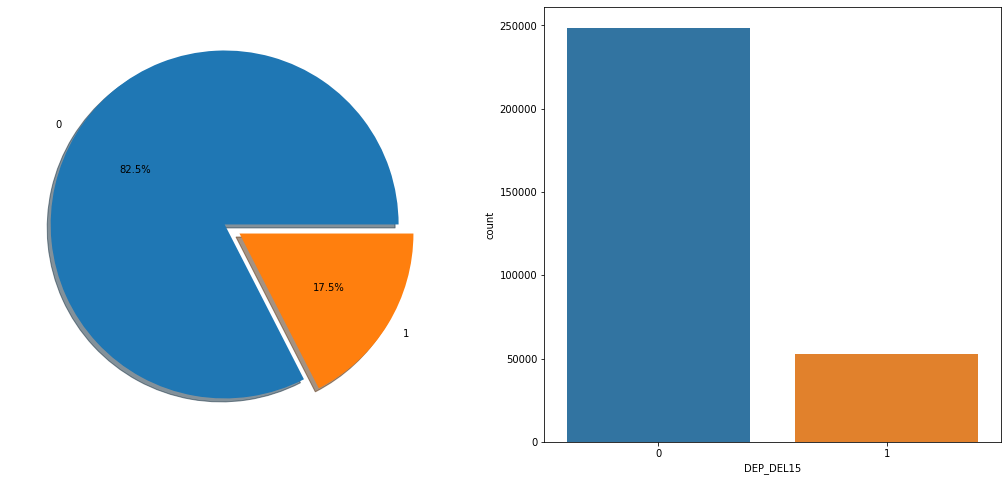

In [116]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

train['DEP_DEL15'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
# ax[0].set_title('Pie plot - Delay')
ax[0].set_ylabel('')
sns.countplot('DEP_DEL15', data=train, ax=ax[1])
# ax[1].set_title('Count plot - Delay')

plt.show()

([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

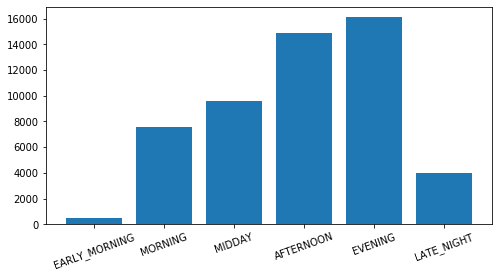

In [117]:
time_target = train[['DEP_BLOCK', 'DEP_DEL15']].groupby(['DEP_BLOCK']).sum().reset_index()

time_target = time_target.reindex(index=[1, 5, 4, 0, 2, 3])

plt.figure(figsize=(8,4))
plt.bar(time_target['DEP_BLOCK'], time_target['DEP_DEL15'])
plt.xticks(rotation=20)

<BarContainer object of 15 artists>

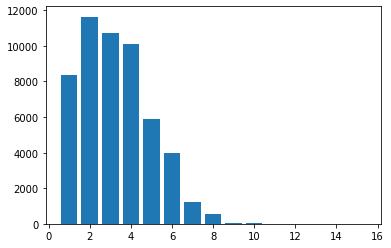

In [118]:
segment_target = train[['SEGMENT_NUMBER', 'DEP_DEL15']].groupby(['SEGMENT_NUMBER']).sum().reset_index()

plt.figure(figsize=(6,4))
plt.bar(segment_target['SEGMENT_NUMBER'], segment_target['DEP_DEL15'])


(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text xticklabel objects>)

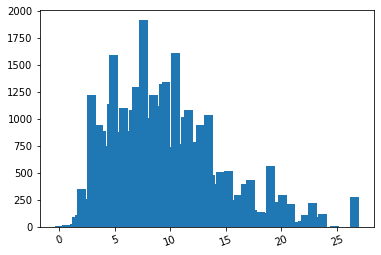

In [119]:
wind_target = train[['AWND', 'DEP_DEL15']].groupby(['AWND']).sum().reset_index()

plt.figure(figsize=(6,4))
plt.bar(wind_target['AWND'], wind_target['DEP_DEL15'])
plt.xticks(rotation=20)

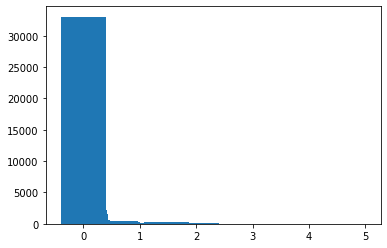

In [120]:
rain_target = train[['PRCP', 'DEP_DEL15']].groupby(['PRCP']).sum().reset_index()

plt.figure(figsize=(6,4))
plt.bar(rain_target['PRCP'], rain_target['DEP_DEL15'])


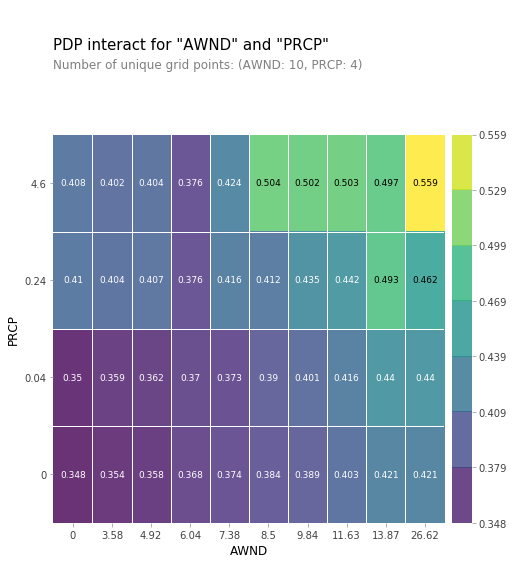

In [121]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['AWND', 'PRCP']

interaction = pdp_interact(
    model=pipe_tree, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [122]:
!pip install shap

In [123]:
print('검증세트 정확도', pipe_best.score(X_test, y_test))
y_pred_test = pipe_best.predict(X_test)
print('검증 f1:', f1_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

검증세트 정확도 0.839179364605119
검증 f1: 0.24088003008649866
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     82874
           1       0.69      0.15      0.24     17536

    accuracy                           0.84    100410
   macro avg       0.77      0.57      0.58    100410
weighted avg       0.82      0.84      0.79    100410



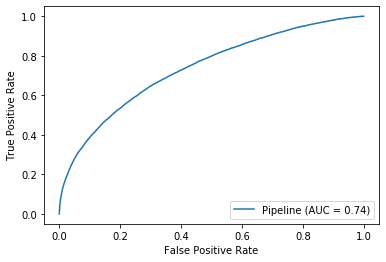

In [124]:
metrics.plot_roc_curve(pipe_best, X_test, y_test)

In [125]:
print('검증세트 정확도', pipe_lg_best.score(X_test, y_test))
y_pred_test = pipe_lg_best.predict(X_test)
print('검증 f1:', f1_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

검증세트 정확도 0.576018324868041
검증 f1: 0.2725719362996377
              precision    recall  f1-score   support

           0       0.84      0.60      0.70     82874
           1       0.19      0.45      0.27     17536

    accuracy                           0.58    100410
   macro avg       0.52      0.53      0.49    100410
weighted avg       0.73      0.58      0.63    100410



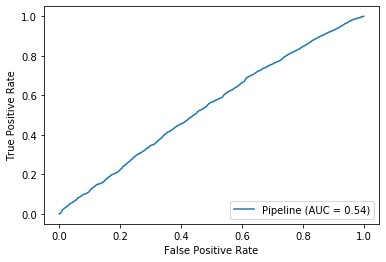

In [126]:
metrics.plot_roc_curve(pipe_lg_best, X_test, y_test)

In [127]:
print('검증세트 정확도', pipe_tree.score(X_test, y_test))
y_pred_test = pipe_tree.predict(X_test)
print('검증 f1:', f1_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

검증세트 정확도 0.6699432327457424
검증 f1: 0.37134131304892165
              precision    recall  f1-score   support

           0       0.88      0.69      0.78     82874
           1       0.28      0.56      0.37     17536

    accuracy                           0.67    100410
   macro avg       0.58      0.63      0.57    100410
weighted avg       0.78      0.67      0.71    100410



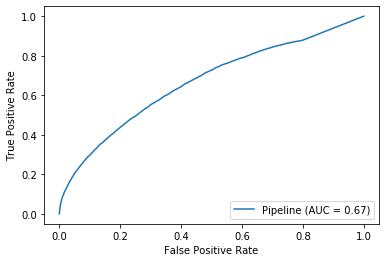

In [128]:
metrics.plot_roc_curve(pipe_tree, X_test, y_test)

In [129]:
print('검증세트 정확도', pipe_xgb_best.score(X_test, y_test))
y_pred_test = pipe_xgb_best.predict(X_test)
print('검증 f1:', f1_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

검증세트 정확도 0.8365302260731002
검증 f1: 0.19837858956827503
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     82874
           1       0.69      0.12      0.20     17536

    accuracy                           0.84    100410
   macro avg       0.77      0.55      0.55    100410
weighted avg       0.81      0.84      0.78    100410



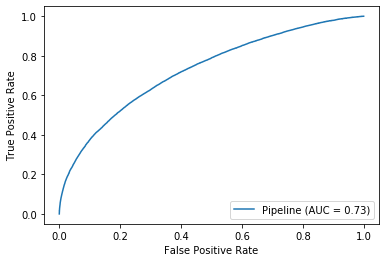

In [130]:
metrics.plot_roc_curve(pipe_xgb_best, X_test, y_test)

In [131]:
output.eval_js('new Audio("https://freesound.org/data/previews/584/584123_13121163-lq.mp3").play()')

(array([2.6293e+05, 1.1864e+04, 6.7640e+03, 6.3200e+03, 4.4250e+03,
        2.3950e+03, 1.6490e+03, 1.4380e+03, 1.5290e+03, 7.5900e+02,
        2.3600e+02, 3.8800e+02, 1.0200e+02, 3.2200e+02, 0.0000e+00,
        3.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.3000e+01]),
 array([0.   , 0.184, 0.368, 0.552, 0.736, 0.92 , 1.104, 1.288, 1.472,
        1.656, 1.84 , 2.024, 2.208, 2.392, 2.576, 2.76 , 2.944, 3.128,
        3.312, 3.496, 3.68 , 3.864, 4.048, 4.232, 4.416, 4.6  ]),
 <a list of 25 Patch objects>)

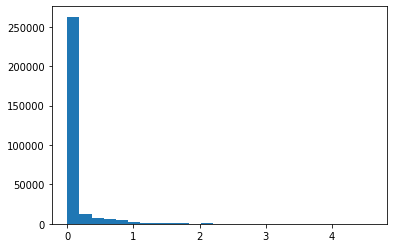

In [132]:
plt.hist(train['PRCP'], bins=25)

(array([  187.,  4413., 18126., 26557., 31489., 28192., 28165., 33790.,
        19778., 25572., 22469., 15778., 11711.,  8115.,  6511.,  5016.,
         3586.,  4448.,  2311.,  2316.,   689.,  1231.,   242.,    63.,
          475.]),
 array([ 0.    ,  1.0648,  2.1296,  3.1944,  4.2592,  5.324 ,  6.3888,
         7.4536,  8.5184,  9.5832, 10.648 , 11.7128, 12.7776, 13.8424,
        14.9072, 15.972 , 17.0368, 18.1016, 19.1664, 20.2312, 21.296 ,
        22.3608, 23.4256, 24.4904, 25.5552, 26.62  ]),
 <a list of 25 Patch objects>)

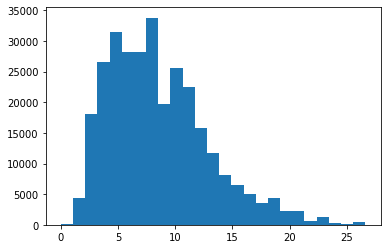

In [133]:
plt.hist(train['AWND'], bins=25)